In [99]:
import os
import time 
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
import os
from sklearn.linear_model import BayesianRidge as br
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import ElasticNet as en
from sklearn.kernel_ridge import KernelRidge as kr
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import logging
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("d:/tianchi/happiness/happiness_train_complete.csv", parse_dates=['survey_time'], encoding='latin-1') 
test = pd.read_csv("d:/tianchi/happiness/happiness_test_complete.csv", parse_dates=['survey_time'], encoding='latin-1')
train = train[train["happiness"]!=-8].reset_index(drop=True)
train_data_copy = train.copy()
target_col = "happiness"
target = train_data_copy[target_col]
del train_data_copy[target_col]

data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)

In [3]:
train.happiness.describe()

count    7988.000000
mean        3.867927
std         0.818717
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: happiness, dtype: float64

In [4]:
#make feature 139 +5 = 144
def getres1(row):
    return len([x for x in row.values if type(x)==int and x<0])

def getres2(row):
    return len([x for x in row.values if type(x)==int and x==-8])

def getres3(row):
    return len([x for x in row.values if type(x)==int and x==-1])

def getres4(row):
    return len([x for x in row.values if type(x)==int and x==-2])

def getres5(row):
    return len([x for x in row.values if type(x)==int and x==-3])

#调查问卷有效程度
data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
data.loc[data['neg1']>20,'neg1'] = 20  #平滑处理

data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)




In [5]:
#填充缺失值 共25列 去掉4列 填充21列

data['work_status'] = data['work_status'].fillna(0)
data['work_yr'] = data['work_yr'].fillna(0)
data['work_manage'] = data['work_manage'].fillna(0)
data['work_type'] = data['work_type'].fillna(0)

data['edu_yr'] = data['edu_yr'].fillna(0)
data['edu_status'] = data['edu_status'].fillna(0)

data['s_work_type'] = data['s_work_type'].fillna(0)
data['s_work_status'] = data['s_work_status'].fillna(0)
data['s_political'] = data['s_political'].fillna(0)
data['s_hukou'] = data['s_hukou'].fillna(0)
data['s_income'] = data['s_income'].fillna(0)
data['s_birth'] = data['s_birth'].fillna(0)
data['s_edu'] = data['s_edu'].fillna(0)
data['s_work_exper'] = data['s_work_exper'].fillna(0)

data['minor_child'] = data['minor_child'].fillna(0)
data['marital_now'] = data['marital_now'].fillna(0)
data['marital_1st'] = data['marital_1st'].fillna(0)
data['social_neighbor']=data['social_neighbor'].fillna(0)
data['social_friend']=data['social_friend'].fillna(0)
data['hukou_loc']=data['hukou_loc'].fillna(1)
data['family_income']=data['family_income'].fillna(66365)



In [7]:
#144+1 =145
data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')
data['survey_time'] = data['survey_time'].dt.year
data['age'] = data['survey_time']-data['birth']
#年龄分箱 145+1=146
bins = [0,17,26,34,50,63,100]
data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5])
#对‘宗教’处理
data.loc[data['religion']<0,'religion'] = 1
data.loc[data['religion_freq']<0,'religion_freq'] = 1
#对‘教育程度’处理
data.loc[data['edu']<0,'edu'] = 4
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['edu_yr']<0,'edu_yr'] = 0
#对‘个人收入’处理
data.loc[data['income']<0,'income'] = 0
#对‘政治面貌’处理
data.loc[data['political']<0,'political'] = 1
#对体重处理
data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2
#对身高处理
data.loc[data['height_cm']<150,'height_cm'] = 150
#对‘健康’处理
data.loc[data['health']<0,'health'] = 4
data.loc[data['health_problem']<0,'health_problem'] = 4
#对‘沮丧’处理
data.loc[data['depression']<0,'depression'] = 4
#对‘媒体’处理
data.loc[data['media_1']<0,'media_1'] = 1
data.loc[data['media_2']<0,'media_2'] = 1
data.loc[data['media_3']<0,'media_3'] = 1
data.loc[data['media_4']<0,'media_4'] = 1
data.loc[data['media_5']<0,'media_5'] = 1
data.loc[data['media_6']<0,'media_6'] = 1
#对‘空闲活动’处理
data.loc[data['leisure_1']<0,'leisure_1'] = 1
data.loc[data['leisure_2']<0,'leisure_2'] = 5
data.loc[data['leisure_3']<0,'leisure_3'] = 3
data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode()
data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
data.loc[data['socialize']<0,'socialize'] = 2
data.loc[data['relax']<0,'relax'] = 4
data.loc[data['learn']<0,'learn'] = 1
#对‘社交’处理
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
data.loc[data['social_friend']<0,'social_friend'] = 0
data.loc[data['socia_outing']<0,'socia_outing'] = 1
data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
#对‘社会公平性’处理
data.loc[data['equity']<0,'equity'] = 4
#对‘社会等级’处理
data.loc[data['class_10_before']<0,'class_10_before'] = 3
data.loc[data['class']<0,'class'] = 5
data.loc[data['class_10_after']<0,'class_10_after'] = 5
data.loc[data['class_14']<0,'class_14'] = 2
#对‘工作情况’处理
data.loc[data['work_status']<0,'work_status'] = 0
data.loc[data['work_yr']<0,'work_yr'] = 0
data.loc[data['work_manage']<0,'work_manage'] = 0
data.loc[data['work_type']<0,'work_type'] = 0
#对‘社会保障’处理
data.loc[data['insur_1']<0,'insur_1'] = 1
data.loc[data['insur_2']<0,'insur_2'] = 1
data.loc[data['insur_3']<0,'insur_3'] = 1
data.loc[data['insur_4']<0,'insur_4'] = 1
data.loc[data['insur_1']==0,'insur_1'] = 0
data.loc[data['insur_2']==0,'insur_2'] = 0
data.loc[data['insur_3']==0,'insur_3'] = 0
data.loc[data['insur_4']==0,'insur_4'] = 0

#对家庭情况处理
family_income_mean = data['family_income'].mean()
data.loc[data['family_income']<0,'family_income'] = family_income_mean
data.loc[data['family_m']<0,'family_m'] = 2
data.loc[data['family_status']<0,'family_status'] = 3
data.loc[data['house']<0,'house'] = 1
data.loc[data['car']<0,'car'] = 0
data.loc[data['car']==2,'car'] = 0
data.loc[data['son']<0,'son'] = 1
data.loc[data['daughter']<0,'daughter'] = 0
data.loc[data['minor_child']<0,'minor_child'] = 0
#对‘婚姻’处理
data.loc[data['marital_1st']<0,'marital_1st'] = 0
data.loc[data['marital_now']<0,'marital_now'] = 0
#对‘配偶’处理
data.loc[data['s_birth']<0,'s_birth'] = 0
data.loc[data['s_edu']<0,'s_edu'] = 0
data.loc[data['s_political']<0,'s_political'] = 0
data.loc[data['s_hukou']<0,'s_hukou'] = 0
data.loc[data['s_income']<0,'s_income'] = 0
data.loc[data['s_work_type']<0,'s_work_type'] = 0
data.loc[data['s_work_status']<0,'s_work_status'] = 0
data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
#对‘父母情况’处理
data.loc[data['f_birth']<0,'f_birth'] = 1945
data.loc[data['f_edu']<0,'f_edu'] = 1
data.loc[data['f_political']<0,'f_political'] = 1
data.loc[data['f_work_14']<0,'f_work_14'] = 2
data.loc[data['m_birth']<0,'m_birth'] = 1940
data.loc[data['m_edu']<0,'m_edu'] = 1
data.loc[data['m_political']<0,'m_political'] = 1
data.loc[data['m_work_14']<0,'m_work_14'] = 2
#和同龄人相比社会经济地位
data.loc[data['status_peer']<0,'status_peer'] = 2
#和3年前比社会经济地位
data.loc[data['status_3_before']<0,'status_3_before'] = 2
#对‘观点’处理
data.loc[data['view']<0,'view'] = 4
#对期望年收入处理
data.loc[data['inc_ability']<=0,'inc_ability']= 2
inc_exp_mean = data['inc_exp'].mean()
data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean

#部分特征处理
for i in range(1,9+1):
    data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = data['public_service_'+str(i)].dropna().mode().values
for i in range(1,13+1):
    data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data['trust_'+str(i)].dropna().mode().values

#第一次结婚年龄 147
data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
#最近结婚年龄 148
data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
#是否再婚 149
data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
#配偶年龄 150
data['marital_sbir'] = data['marital_now']-data['s_birth']
#配偶年龄差 151
data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

#收入比 151+7 =158
data['income/s_income'] = data['income']/(data['s_income']+1)
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
data['income/m'] = data['income']/(data['family_m']+0.01)

#收入/面积比 158+4=162
data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

#class 162+3=165
data['class_10_diff'] = (data['class_10_after'] - data['class'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']
#悠闲指数 166
leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew
#满意指数 167
public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

#信任指数 168
trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

#province mean 168+13=181
data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

#city   mean 181+13=194
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

#county  mean 194 + 13 = 207
data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

#ratio 相比同省 207 + 13 =220
data['income/province'] = data['income']/(data['province_income_mean'])                                      
data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
data['equity/province'] = data['equity']/(data['province_equity_mean'])       
data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
data['health/province'] = data['health']/(data['province_health_mean'])
data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
data['class/province'] = data['class']/(data['province_class_mean'])
data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

#ratio 相比同市 220 + 13 =233
data['income/city'] = data['income']/(data['city_income_mean'])                                      
data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
data['equity/city'] = data['equity']/(data['city_equity_mean'])       
data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
data['health/city'] = data['health']/(data['city_health_mean'])
data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
data['class/city'] = data['class']/(data['city_class_mean'])
data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])

#ratio 相比同个地区 233 + 13 =246
data['income/county'] = data['income']/(data['county_income_mean'])                                      
data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
data['equity/county'] = data['equity']/(data['county_equity_mean'])       
data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
data['health/county'] = data['health']/(data['county_health_mean'])
data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
data['class/county'] = data['class']/(data['county_class_mean'])
data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])

#age   mean 246+ 13 =259
data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values

# 和同龄人相比259 + 13 =272
data['income/age'] = data['income']/(data['age_income_mean'])                                      
data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
data['equity/age'] = data['equity']/(data['age_equity_mean'])       
data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
data['health/age'] = data['health']/(data['age_health_mean'])
data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
data['class/age'] = data['class']/(data['age_class_mean'])
data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])


print('shape',data.shape)
data.head()



shape (10956, 272)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,depression/age,floor_area/age,health/age,class_10_diff/age,class/age,health_problem/age,family_status/age,leisure_sum/age,public_service_sum/age,trust_sum/age
0,1,1,12,32,59,1970,1,1959,1,1,...,1.285211,0.410351,0.848837,0.000000,0.683307,0.521429,0.733668,0.724620,0.666638,0.925941
1,2,2,18,52,85,1970,1,1992,1,1,...,0.733333,0.952824,1.179337,1.012552,1.344444,0.891344,1.359551,1.011792,1.130778,1.188442
2,3,2,29,83,126,1970,2,1967,1,0,...,1.343537,0.972328,1.150485,1.190955,1.195762,1.055679,1.190955,0.966470,1.193204,0.803693
3,4,2,10,28,51,1970,2,1943,1,1,...,1.111663,0.642329,1.276353,4.977778,1.199143,1.188329,1.162630,0.899346,1.153810,1.300950
4,5,1,7,18,36,1970,2,1994,1,1,...,0.750000,0.587284,1.177106,0.000000,0.236957,1.116803,1.093645,1.045313,0.728161,1.117428


In [9]:
#272-9=263
del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
use_feature = [clo for clo in data.columns if clo not in del_list]
data.fillna(0,inplace=True)
train_shape = train.shape[0]
features = data[use_feature].columns
X_train_263 = data[:train_shape][use_feature].values
y_train = target
X_test_263 = data[train_shape:][use_feature].values
X_train_263.shape

(7988, 263)

In [23]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
           'equity/province','equity/city','equity/county',
           'depression/province','depression/city','depression/county',
           'health/province','health/city','health/county',
           'class/province','class/city','class/county',
           'family_status/province','family_status/city','family_status/county',
           'family_income/province','family_income/city','family_income/county',
           'floor_area/province','floor_area/city','floor_area/county',
           'leisure_sum/province','leisure_sum/city','leisure_sum/county',
           'public_service_sum/province','public_service_sum/city','public_service_sum/county',
           'trust_sum/province','trust_sum/city','trust_sum/county',
           'income/m','public_service_sum','class_diff','status_3_before','age_income_mean','age_floor_area_mean',
           'weight_jin','height_cm',
           'health/age','depression/age','equity/age','leisure_sum/age'
          ]
train_shape = train.shape[0]
X_train_49 = data[:train_shape][imp_fea_49].values
X_test_49 = data[train_shape:][imp_fea_49].values
X_train_49.shape

(7988, 49)

In [12]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14']
noc_fea = [clo for clo in use_feature if clo not in cat_fea]

len(noc_fea)

242

In [15]:
onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories='auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape

(10956, 141)

In [16]:
X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape

(7988, 141)

In [18]:
X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7988, 383)

In [28]:
##### lgb_263
lgb_263_param = {
'num_leaves': 7,
'min_data_in_leaf': 20,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.003,
"boosting": "gbdt",
"feature_fraction": 0.18,
"bagging_freq": 1,
"bagging_fraction": 0.55,
"bagging_seed": 14,
"metric": 'mse',
"lambda_l1": 0.1005,
"lambda_l2": 0.1996, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)   
oof_lgb_263 = np.zeros(len(X_train_263))
predictions_lgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_263[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_263[val_idx], y_train[val_idx])

    num_round = 10000
    lgb_263 = lgb.train(lgb_263_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 800)
    oof_lgb_263[val_idx] = lgb_263.predict(X_train_263[val_idx], num_iteration=lgb_263.best_iteration)
    predictions_lgb_263 += lgb_263.predict(X_test_263, num_iteration=lgb_263.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_263, target)))

fold n°1
Training until validation scores don't improve for 800 rounds.
[500]	training's l2: 0.506716	valid_1's l2: 0.509632
[1000]	training's l2: 0.459112	valid_1's l2: 0.470082
[1500]	training's l2: 0.433129	valid_1's l2: 0.454055
[2000]	training's l2: 0.4152	valid_1's l2: 0.445279
[2500]	training's l2: 0.401025	valid_1's l2: 0.440707
[3000]	training's l2: 0.388743	valid_1's l2: 0.437664
[3500]	training's l2: 0.377994	valid_1's l2: 0.43575
[4000]	training's l2: 0.368085	valid_1's l2: 0.434466
[4500]	training's l2: 0.358898	valid_1's l2: 0.43354
[5000]	training's l2: 0.350405	valid_1's l2: 0.432736
[5500]	training's l2: 0.342336	valid_1's l2: 0.432232
[6000]	training's l2: 0.334708	valid_1's l2: 0.43205
[6500]	training's l2: 0.32737	valid_1's l2: 0.431651
[7000]	training's l2: 0.320311	valid_1's l2: 0.431429
[7500]	training's l2: 0.313477	valid_1's l2: 0.431256
[8000]	training's l2: 0.307032	valid_1's l2: 0.430874
[8500]	training's l2: 0.300733	valid_1's l2: 0.430899
[9000]	training's

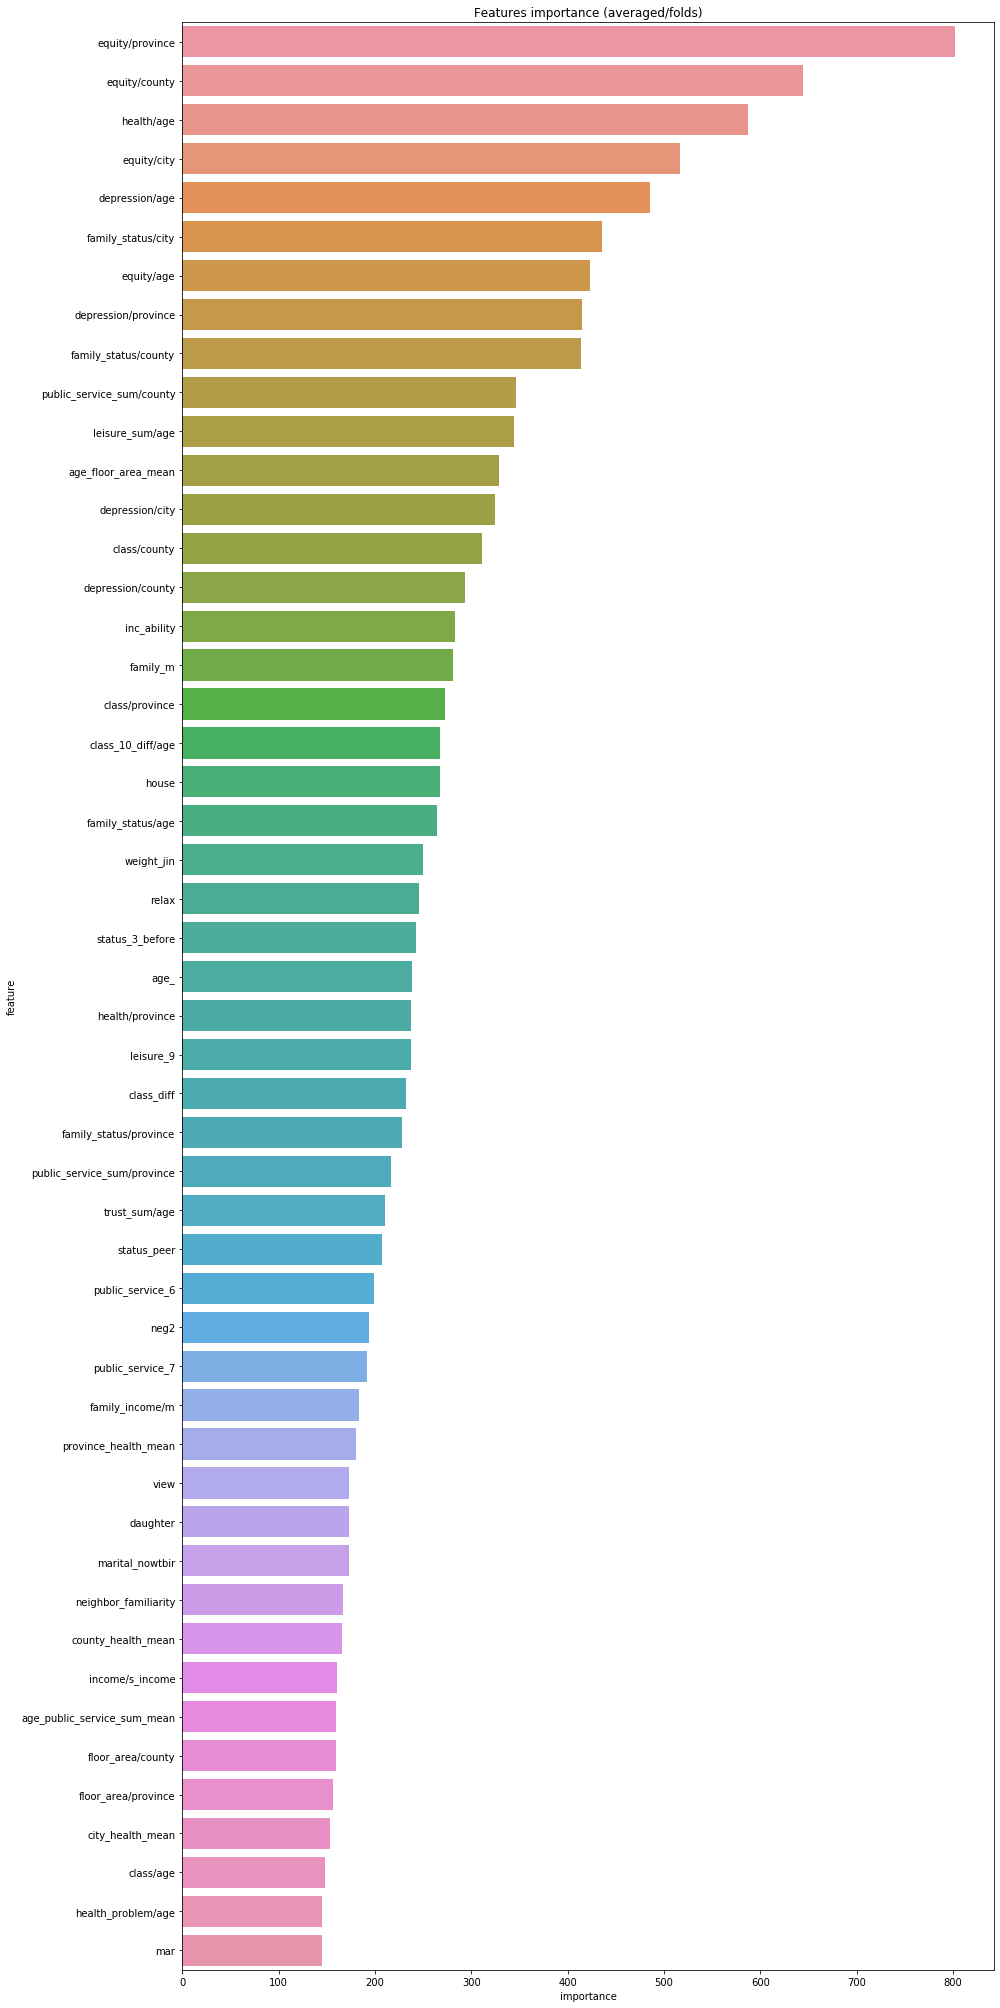

In [22]:
#---------------特征重要性
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[use_feature].columns.tolist(), columns=['feature'])
df['importance']=list(lgb_263.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [31]:
##### xgb_263
xgb_263_params = {'eta': 0.02, 
              'max_depth': 6, 
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7, 
              'colsample_bytree': 0.3, 
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_263 = np.zeros(len(X_train_263))
predictions_xgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_263[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_263[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_263 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_263_params)
    oof_xgb_263[val_idx] = xgb_263.predict(xgb.DMatrix(X_train_263[val_idx]), ntree_limit=xgb_263.best_ntree_limit)
    predictions_xgb_263 += xgb_263.predict(xgb.DMatrix(X_test_263), ntree_limit=xgb_263.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_263, target)))

fold n°1
[0]	train-rmse:3.40431	valid_data-rmse:3.38326
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[500]	train-rmse:0.406018	valid_data-rmse:0.706535
[1000]	train-rmse:0.272424	valid_data-rmse:0.709464
Stopping. Best iteration:
[445]	train-rmse:0.423487	valid_data-rmse:0.705639

fold n°2
[0]	train-rmse:3.39808	valid_data-rmse:3.40794
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[500]	train-rmse:0.406888	valid_data-rmse:0.689693
[1000]	train-rmse:0.273509	valid_data-rmse:0.692095
Stopping. Best iteration:
[523]	train-rmse:0.399233	valid_data-rmse:0.689412

fold n°3
[0]	train-rmse:3.40186	valid_data-rmse:3.3931
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[50

In [32]:
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_rfr_263 = np.zeros(len(X_train_263))
predictions_rfr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    rfr_263 = rfr(n_estimators=1600,max_depth=9, min_samples_leaf=9, min_weight_fraction_leaf=0.0,
            max_features=0.25,verbose=1,n_jobs=-1)
    rfr_263.fit(tr_x,tr_y)
    oof_rfr_263[val_idx] = rfr_263.predict(X_train_263[val_idx])
    
    predictions_rfr_263 += rfr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_rfr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   16.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   20.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   19.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   19.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   20.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

CV score: 0.47807088


[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.2s finished


In [34]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
oof_gbr_263 = np.zeros(train_shape)
predictions_gbr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_263 = gbr(n_estimators=400, learning_rate=0.01,subsample=0.65,max_depth=7, min_samples_leaf=20,
            max_features=0.22,verbose=1)
    gbr_263.fit(tr_x,tr_y)
    oof_gbr_263[val_idx] = gbr_263.predict(X_train_263[val_idx])
    
    predictions_gbr_263 += gbr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_263, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6676           0.0067           26.79s
         2           0.6435           0.0063           27.22s
         3           0.6581           0.0063           25.71s
         4           0.6306           0.0062           25.17s
         5           0.6414           0.0053           24.93s
         6           0.6212           0.0051           25.23s
         7           0.6099           0.0056           25.09s
         8           0.5999           0.0054           24.73s
         9           0.5774           0.0049           24.39s
        10           0.6056           0.0045           24.25s
        20           0.5247           0.0033           22.92s
        30           0.5033           0.0024           22.46s
        40           0.4667           0.0016           21.59s
        50           0.4262           0.0010           21.10s
        60           0.4026           0.0008           20.66

In [37]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_etr_263 = np.zeros(train_shape)
predictions_etr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    etr_263 = etr(n_estimators=1000,max_depth=8, min_samples_leaf=12, min_weight_fraction_leaf=0.0,
            max_features=0.4,verbose=1,n_jobs=-1)
    etr_263.fit(tr_x,tr_y)
    oof_etr_263[val_idx] = etr_263.predict(X_train_263[val_idx])
    
    predictions_etr_263 += etr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_etr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elaps

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elaps

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elaps

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elaps

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elaps

CV score: 0.48597395


In [51]:
train_stack2 = np.vstack([oof_lgb_263,oof_xgb_263,oof_gbr_263,oof_rfr_263,oof_etr_263]).transpose()
test_stack2 = np.vstack([predictions_lgb_263, predictions_xgb_263,predictions_gbr_263,predictions_rfr_263,predictions_etr_263]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack2 = np.zeros(train_stack2.shape[0])
predictions_lr2 = np.zeros(test_stack2.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack2,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack2[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack2[val_idx], target.iloc[val_idx].values
    
    lr2 = kr()
    lr2.fit(trn_data, trn_y)
    
    oof_stack2[val_idx] = lr2.predict(val_data)
    predictions_lr2 += lr2.predict(test_stack2) / 10
    
mean_squared_error(target.values, oof_stack2) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4480463968181281

In [67]:
##### lgb_49
lgb_49_param = {
'num_leaves': 9,
'min_data_in_leaf': 23,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.002,
"boosting": "gbdt",
"feature_fraction": 0.45,
"bagging_freq": 1,
"bagging_fraction": 0.65,
"bagging_seed": 15,
"metric": 'mse',
"lambda_l2": 0.2, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)   
oof_lgb_49 = np.zeros(len(X_train_49))
predictions_lgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_49[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_49[val_idx], y_train[val_idx])

    num_round = 12000
    lgb_49 = lgb.train(lgb_49_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof_lgb_49[val_idx] = lgb_49.predict(X_train_49[val_idx], num_iteration=lgb_49.best_iteration)
    predictions_lgb_49 += lgb_49.predict(X_test_49, num_iteration=lgb_49.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_49, target)))

fold n°1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l2: 0.469917	valid_1's l2: 0.500224
[2000]	training's l2: 0.429395	valid_1's l2: 0.481374
[3000]	training's l2: 0.406698	valid_1's l2: 0.477093
[4000]	training's l2: 0.3889	valid_1's l2: 0.47561
[5000]	training's l2: 0.37349	valid_1's l2: 0.474608
[6000]	training's l2: 0.359817	valid_1's l2: 0.474433
[7000]	training's l2: 0.347254	valid_1's l2: 0.474529
Early stopping, best iteration is:
[6424]	training's l2: 0.35435	valid_1's l2: 0.474245
fold n°2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l2: 0.469704	valid_1's l2: 0.497032
[2000]	training's l2: 0.428488	valid_1's l2: 0.479522
[3000]	training's l2: 0.405835	valid_1's l2: 0.476507
[4000]	training's l2: 0.388049	valid_1's l2: 0.475179
[5000]	training's l2: 0.372573	valid_1's l2: 0.474548
[6000]	training's l2: 0.358813	valid_1's l2: 0.474523
Early stopping, best iteration is:
[5486]	training's l2: 0.365728	va

In [154]:
##### xgb_49
xgb_49_params = {'eta': 0.02, 
              'max_depth': 5, 
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7, 
              'colsample_bytree': 0.35, 
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_49 = np.zeros(len(X_train_49))
predictions_xgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_49[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_49[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_49 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_49_params)
    oof_xgb_49[val_idx] = xgb_49.predict(xgb.DMatrix(X_train_49[val_idx]), ntree_limit=xgb_49.best_ntree_limit)
    predictions_xgb_49 += xgb_49.predict(xgb.DMatrix(X_test_49), ntree_limit=xgb_49.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_49, target)))

fold n°1
[0]	train-rmse:3.40422	valid_data-rmse:3.38325
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[500]	train-rmse:0.527937	valid_data-rmse:0.718854
[1000]	train-rmse:0.435462	valid_data-rmse:0.720046
Stopping. Best iteration:
[529]	train-rmse:0.521913	valid_data-rmse:0.718483

fold n°2
[0]	train-rmse:3.39826	valid_data-rmse:3.40774
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[500]	train-rmse:0.528483	valid_data-rmse:0.70254
[1000]	train-rmse:0.438964	valid_data-rmse:0.703679
Stopping. Best iteration:
[600]	train-rmse:0.509122	valid_data-rmse:0.701535

fold n°3
[0]	train-rmse:3.40192	valid_data-rmse:3.39291
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 600 rounds.
[50

In [74]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
oof_gbr_49 = np.zeros(train_shape)
predictions_gbr_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_49 = gbr(n_estimators=600, learning_rate=0.01,subsample=0.65,max_depth=6, min_samples_leaf=20,
            max_features=0.35,verbose=1)
    gbr_49.fit(tr_x,tr_y)
    oof_gbr_49[val_idx] = gbr_49.predict(X_train_49[val_idx])
    
    predictions_gbr_49 += gbr_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_49, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6678           0.0034            8.77s
         2           0.6444           0.0031           11.10s
         3           0.6644           0.0030           10.49s
         4           0.6452           0.0032            9.90s
         5           0.6422           0.0032            9.53s
         6           0.6596           0.0029            9.19s
         7           0.6444           0.0029            8.93s
         8           0.6397           0.0031            8.81s
         9           0.6441           0.0027            8.78s
        10           0.6207           0.0028            8.70s
        20           0.5861           0.0026            8.48s
        30           0.5525           0.0020            8.27s
        40           0.5583           0.0016            8.15s
        50           0.5307           0.0013            7.94s
        60           0.5366           0.0009            7.91

In [155]:
train_stack3 = np.vstack([oof_lgb_49,oof_xgb_49,oof_gbr_49]).transpose()
test_stack3 = np.vstack([predictions_lgb_49, predictions_xgb_49,predictions_gbr_49]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack3 = np.zeros(train_stack3.shape[0])
predictions_lr3 = np.zeros(test_stack3.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack3,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack3[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack3[val_idx], target.iloc[val_idx].values
    
    lr3 = kr()
    lr3.fit(trn_data, trn_y)
    
    oof_stack3[val_idx] = lr3.predict(val_data)
    predictions_lr3 += lr3.predict(test_stack3) / 10
    
mean_squared_error(target.values, oof_stack3) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.46612748508142104

In [97]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_kr_383 = np.zeros(train_shape)
predictions_kr_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    kr_383 = kr()
    kr_383.fit(tr_x,tr_y)
    oof_kr_383[val_idx] = kr_383.predict(X_train_383[val_idx])
    
    predictions_kr_383 += kr_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_kr_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.51672379


In [94]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_ridge_383 = np.zeros(train_shape)
predictions_ridge_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    ridge_383 = Ridge(alpha=1200)
    ridge_383.fit(tr_x,tr_y)
    oof_ridge_383[val_idx] = ridge_383.predict(X_train_383[val_idx])
    
    predictions_ridge_383 += ridge_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_ridge_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.48663633


In [101]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_en_383 = np.zeros(train_shape)
predictions_en_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    en_383 = en(alpha=1.0,l1_ratio=0.06)
    en_383.fit(tr_x,tr_y)
    oof_en_383[val_idx] = en_383.predict(X_train_383[val_idx])
    
    predictions_en_383 += en_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_en_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.53292758


In [102]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_br_383 = np.zeros(train_shape)
predictions_br_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    br_383 = br()
    br_383.fit(tr_x,tr_y)
    oof_br_383[val_idx] = br_383.predict(X_train_383[val_idx])
    
    predictions_br_383 += br_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_br_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.48690239


In [108]:
train_stack1 = np.vstack([oof_br_383,oof_kr_383,oof_en_383,oof_ridge_383]).transpose()
test_stack1 = np.vstack([predictions_br_383, predictions_kr_383,predictions_en_383,predictions_ridge_383]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack1 = np.zeros(train_stack1.shape[0])
predictions_lr1 = np.zeros(test_stack1.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack1,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack1[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack1[val_idx], target.iloc[val_idx].values
    
    lr1 = lr()
    lr1.fit(trn_data, trn_y)
    
    oof_stack1[val_idx] = lr1.predict(val_data)
    predictions_lr1 += lr1.predict(test_stack1) / 10
    
mean_squared_error(target.values, oof_stack1) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.48741703582621976

In [162]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_kr_49 = np.zeros(train_shape)
predictions_kr_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    kr_49 = kr()
    kr_49.fit(tr_x,tr_y)
    oof_kr_49[val_idx] = kr_49.predict(X_train_49[val_idx])
    
    predictions_kr_49 += kr_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_kr_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.50253564


In [173]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_ridge_49 = np.zeros(train_shape)
predictions_ridge_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    ridge_49 = Ridge(alpha=6)
    ridge_49.fit(tr_x,tr_y)
    oof_ridge_49[val_idx] = ridge_49.predict(X_train_49[val_idx])
    
    predictions_ridge_49 += ridge_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_ridge_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.49448122


In [174]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_br_49 = np.zeros(train_shape)
predictions_br_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    br_49 = br()
    br_49.fit(tr_x,tr_y)
    oof_br_49[val_idx] = br_49.predict(X_train_49[val_idx])
    
    predictions_br_49 += br_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_br_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.49531741


In [179]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_en_49 = np.zeros(train_shape)
predictions_en_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    en_49 = en(alpha=1.0,l1_ratio=0.05)
    en_49.fit(tr_x,tr_y)
    oof_en_49[val_idx] = en_49.predict(X_train_49[val_idx])
    
    predictions_en_49 += en_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_en_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.53837394


In [180]:
train_stack4 = np.vstack([oof_br_49,oof_kr_49,oof_en_49,oof_ridge_49]).transpose()
test_stack4 = np.vstack([predictions_br_49, predictions_kr_49,predictions_en_49,predictions_ridge_49]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack4 = np.zeros(train_stack4.shape[0])
predictions_lr4 = np.zeros(test_stack4.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack4,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack4[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack4[val_idx], target.iloc[val_idx].values
    
    lr4 = lr()
    lr4.fit(trn_data, trn_y)
    
    oof_stack4[val_idx] = lr4.predict(val_data)
    predictions_lr4 += lr4.predict(test_stack1) / 10
    
mean_squared_error(target.values, oof_stack4) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4948833548008857

In [183]:
mean_squared_error(target.values, 0.7*(0.6*oof_stack2 + 0.4*oof_stack3)+0.3*(0.55*oof_stack1+0.45*oof_stack4))

0.45237728799822047

In [191]:
train_stack5 = np.vstack([oof_stack1,oof_stack2,oof_stack3,oof_stack4]).transpose()
test_stack5 = np.vstack([predictions_lr1, predictions_lr2,predictions_lr3,predictions_lr4]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack5 = np.zeros(train_stack5.shape[0])
predictions_lr5= np.zeros(test_stack5.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack5,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack5[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack5[val_idx], target.iloc[val_idx].values
    
    lr5 = lr()
    lr5.fit(trn_data, trn_y)
    
    oof_stack5[val_idx] = lr5.predict(val_data)
    predictions_lr5 += lr5.predict(test_stack5) / 10
    
mean_squared_error(target.values, oof_stack5) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.44761953946346983

In [192]:
submit_example = pd.read_csv('d:/tianchi/happiness/happiness_submit.csv',sep=',',encoding='latin-1')

submit_example['happiness'] = predictions_lr5

submit_example.happiness.describe()

count    2968.000000
mean        3.881401
std         0.535058
min         1.142868
25%         3.669060
50%         3.985149
75%         4.215604
max         5.311432
Name: happiness, dtype: float64

In [193]:
submit_example.loc[submit_example['happiness']>4.96,'happiness']= 5
# submit_example.loc[submit_example['happiness']<=1.2,'happiness']= 1
# submit_example.loc[(submit_example['happiness']>1.95)&(submit_example['happiness']<2.05),'happiness']= 2
# submit_example.loc[(submit_example['happiness']>2.95)&(submit_example['happiness']<3.05),'happiness']= 3
# submit_example.loc[(submit_example['happiness']>3.95)&(submit_example['happiness']<4.05),'happiness']= 4

submit_example.to_csv("d:/tianchi/happiness/submision_stacking_4lr_post_v3.csv",index=False)
submit_example.happiness.describe()

count    2968.000000
mean        3.881187
std         0.534565
min         1.142868
25%         3.669060
50%         3.985149
75%         4.215604
max         5.000000
Name: happiness, dtype: float64